# Cбор данных и анализ групп пользователей социальной сети ВКонтакте


### В качесте двух тематических сообществ были выбраны:
    - Waterparks
    - get your life, 5sos
    Они обе посвещаны музыкальным группам (Waterparks и 5 Seconds Of Summer), выпускающим музыку в похожих жанрах в примерно одинаковый период времени (с 2011 по наст. время)

In [539]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import pickle
import numpy as np
import random
import networkx as nx
import markov_clustering as mc
import time
import csv
import datetime as dt
from datetime import datetime, date, time, timedelta
import vk
import vk_api
import warnings
import re
import seaborn as sns
from collections import Counter
warnings.filterwarnings('ignore')
session = vk.Session(access_token=token) 
vk_api = vk.API(session)

Фунция get_members() получает список всех подписчиков сообщества

In [582]:
def get_members(groupid):
    first = vk_api.groups.getMembers(group_id=groupid, v=5.103) 
    data = first["items"]  
    count = first["count"] // 1000 
    for i in range(1, count+1):  
        data = data + vk_api.groups.getMembers(group_id=groupid, v=5.92, offset=i*1000)["items"]
    return data

Получим список подписчиков для выбранных групп

In [541]:
users_waterparks = get_members('waterparkstx')
users_5sos = get_members('getyourlife') 

In [542]:
print('Количество подписчиков у Waterparks: ', len(users_waterparks))
print('Количество подписчиков у get your life, 5sos: ', len(users_5sos))

Количество подписчиков у Waterparks:  1909
Количество подписчиков у get your life, 5sos:  1938


### Сохраните списки участников выбранных сообществ. Есть ли пользователи, относящиеся к обоим сообществам?

In [567]:
from collections import Counter
common_items = list(set((Counter(users_waterparks) & Counter(users_5sos)).elements()))
print('Количество общих участников - ', len(common_items))

Количество общих участников -  35


### Сохраните последние 2000 постов каждого из сообществ

In [501]:
def take_2000_posts(owner_id):
    all_posts = []
    offset=100
    while offset <= 2000:
        response = requests.get('https://api.vk.com/method/wall.get',
                                params={
                                    'access_token': token_p,
                                    'v': 5.103,
                                    'owner_id': owner_id,
                                    'count': 100,
                                    'offset': offset
                                })
        data = response.json()['response']['items']
        all_posts.extend(data)
        offset += 100
        
    df = pd.DataFrame.from_dict(all_posts, orient='columns')
    df_new = df[['id', 'date', 'text']]
    df_new["post_time"] = pd.NaT
    df_new["hour"] = pd.NaT
    df_new["hashtag"] = [re.findall('#\w+', i) for i in df_new['text']]
    for i in range(0,len(df_new)):
        df_new['post_time'][i] =  dt.datetime.fromtimestamp(
                int(df_new['date'][i])
                ).strftime('%H:%M:%S') 
        df_new['hour'][i] =  dt.datetime.fromtimestamp(
                int(df_new['date'][i])
                ).strftime('%H') 
    df_new.pop('date') 
    return df_new

In [502]:
df_1 = take_2000_posts(-174660174) #5SecondsOfSummer
df_2 = take_2000_posts(-111917537) #Waterparks

In [504]:
df_2

,id,text,post_time,hour,hashtag
0,7432,...а практически сразу после релиза «Watch Wha...,2022-03-30 16:20:01,16,[]
1,7429,"В четверг, 12 сентября, вышла новая песня!\n\n...",2022-03-30 16:15:01,16,[]
2,7425,🌼,2022-03-30 18:59:35,18,[]
3,7418,"Всем привет, Парксы снова в строю и мы вместе ...",2022-03-30 12:05:02,12,[]
4,7411,,2022-03-30 15:22:04,15,[]
...,...,...,...,...,...
1995,3082,#waterparks_APMA2017@waterparkstx \nWaterparks...,2022-03-30 00:42:56,00,[#waterparks_APMA2017]
1996,3081,#waterparks_APMA2017@waterparkstx \nКто-то тут...,2022-03-30 00:35:36,00,"[#waterparks_APMA2017, #APMAS]"
1997,3080,#waterparks_APMA2017@waterparkstx \n Заранее к...,2022-03-30 00:28:57,00,[#waterparks_APMA2017]
1998,3075,"#waterparks_APMA2017@waterparkstx \nСУКА, ОНИ ...",2022-03-30 00:01:27,00,"[#waterparks_APMA2017, #APMAS]"


### Посчитайте количество постов за каждый час суток для обоих сообществ, визуализируйте результаты. В какое время суток наиболее активны участники социальных групп? Совпадают ли часы с наибольшей активностью для обоих сообществ?


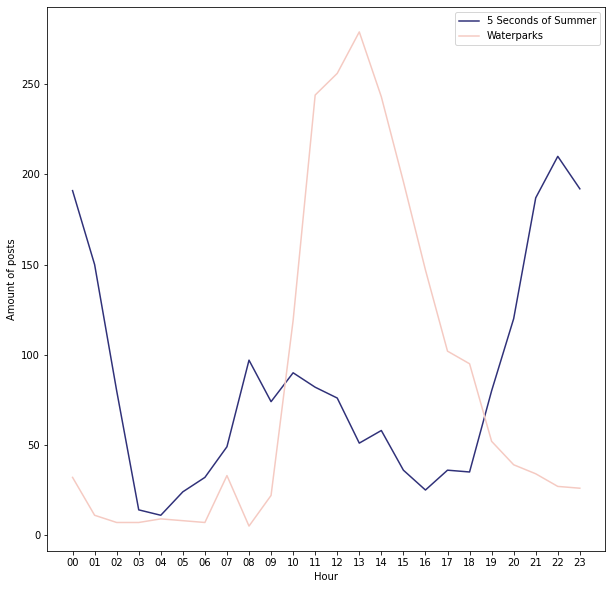

In [445]:
plt.figure(3,figsize=(10,10))
sns.lineplot(x=df_1.hour.value_counts().index.sort_values(), y=df_1.hour.value_counts().sort_index(), color='#303179').set( xlabel = "Hour", ylabel = "Amount of posts")
sns.lineplot(x=df_2.hour.value_counts().index.sort_values(), y=df_2.hour.value_counts().sort_index(), color='#f5cac2').set( xlabel = "Hour", ylabel = "Amount of posts")
plt.legend(labels=["5 Seconds of Summer","Waterparks"])

### Cоставьте топ хэштегов по встречаемости для каждой группы, визуализируйте полученные результаты. Сравните списки на предмет пересечений.

Функция find_similar() сравнивает два датасета и выводит общие хештеги, если такие имеются.

In [580]:
def find_similar(df_1, df_2):
    df1_hashtags = []
    df2_hashtags = []
    for i in range(len(df_1)):
        for j in range(len(df_1['hashtag'][i])):
            df1_hashtags.append(df_1['hashtag'][i][j])
    for m in range(len(df_2)):
        for k in range(len(df_2['hashtag'][m])):
            df2_hashtags.append(df_2['hashtag'][m][k])
    common_hashtags = set(df1_hashtags) & set(df2_hashtags)
    if len(common_hashtags) == 0:
        return 'Нет общих хештегов'
    else: 
        return 'Общие хештеги: {}'.format(common_hashtags)

In [581]:
find_similar(df_1, df_2)

"Общие хештеги: {'#1'}"

Функция top_hashtag() выводит график с 10-ю наиболее встречающимися хештегами для группы

In [407]:
def top_hastag(df_group):
    all_hashtags = []
    for i in range(len(df_group)):
        for j in range(len(df_group['hashtag'][i])):
            all_hashtags.append(df_group['hashtag'][i][j])
    hashtags = dict(Counter(all_hashtags).most_common(10))
    hashtag_count = {k: v for k, v in sorted(hashtags.items(), key=lambda item: item[1])}
    names = list(hashtag_count.keys())
    values = list(hashtag_count.values())
    plt.figure(3,figsize=(10,10))
    color_list = ['#2cbdfe',  '#36b0f8',
                '#3aacf6', '#449ff0',
                '#6379de',  '#6e6cd8',
                '#7168d7', '#7c5bd1',
                '#9b35bf', '#a528b9',
                '#a924b7', '#b317b1']
    plt.barh(range(len(hashtag_count)), values, tick_label=names, color=color_list)
    plt.show()
    return None

#### Топ-10 хештегов для 5 Seconds Of Summer

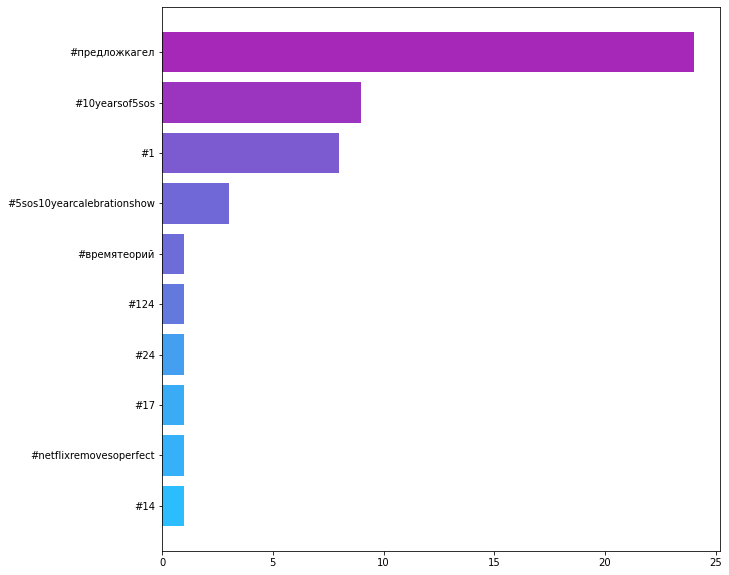

In [408]:
top_hastag(df_1) 

### Топ-10 хештегов для Waterparks

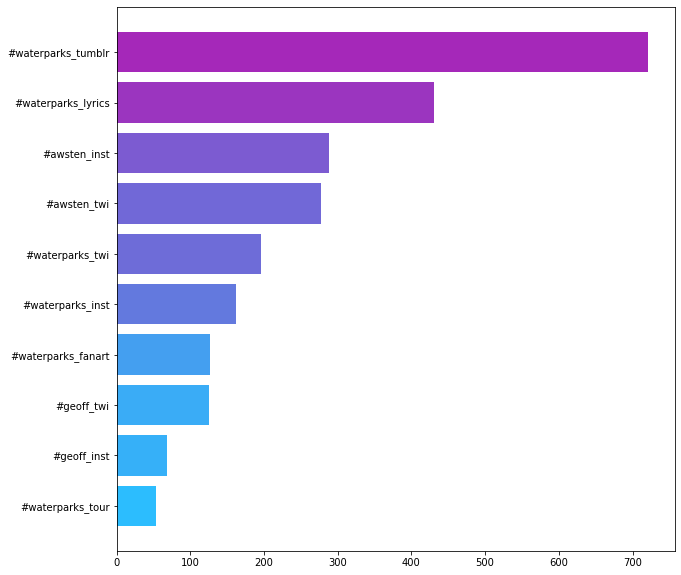

In [ ]:
top_hastag(df_2)

### Постройте социальные графы для обоих сообществ.

Функция user_friends_list() принимает id подписчика сообщества и список id всех подписчиков, а на выходе получается словарь, который в качества ключа содержит id пользователя, а в качестве значения тоже словарь с ключами 'u_count' (значение - кол-во друзей среди подписчиков) и 'u_list' (список друзей среди подписчиков).

In [556]:
dict_friends = {}
def user_friends_list(user_id, group_users):
    count = requests.get('https://api.vk.com/method/friends.get?', params={
                'access_token':token_p,
                'v':5.103,
                'user_id': user_id,
            }).json()
        
    if 'error' in count.keys():
        return count
    
    users_info = {}
    users_info['u_list'] = list(set(count['response']['items']).intersection(group_users))
    users_info['u_count'] = len(list(set(count['response']['items']).intersection(group_users)))
    
    dict_friends[user_id] = users_info
    
    return None

Функция make_graph() создает граф, отражающий взаимосвязи подписчиков сообщества

In [554]:
def make_graph(groups_out):
    graph = nx.petersen_graph()
    vk_edges = []
    for key, value in groups_out.items():
        if groups_out[key]['u_count'] != 0:
            graph.add_node(key, size=groups_out[key]['u_count'])
            for i in range(int(groups_out[key]['u_count'])):
                vk_edges.append((key, dict_friends[key]['u_list'][i]))
            graph.add_edges_from(vk_edges)
    plt.figure(3,figsize=(20,20))
    nx.draw_spring(graph, with_labels=False, font_weight='light', node_size = 20, width=0.5)
    plt.show()
    return graph

In [552]:
def clustering(graph):
    numnodes = len(graph.nodes())
    positions = {i:(random.random() * 2 - 1, random.random() * 2 - 1) for i in range(numnodes)}
    plt.figure(3,figsize=(25,25))
    matrix = nx.to_scipy_sparse_array(graph)
    result = mc.run_mcl(matrix)           
    clusters = mc.get_clusters(result)
    mc.draw_graph(matrix, clusters, node_size=50, with_labels=False, edge_color="silver")
    return 'Количество кластеров: {}'.format(len(clusters))

### Социальный граф для Waterparks

In [547]:
for i in range(len(users_waterparks)):
    user_friends_list(users_waterparks[i], users_waterparks)

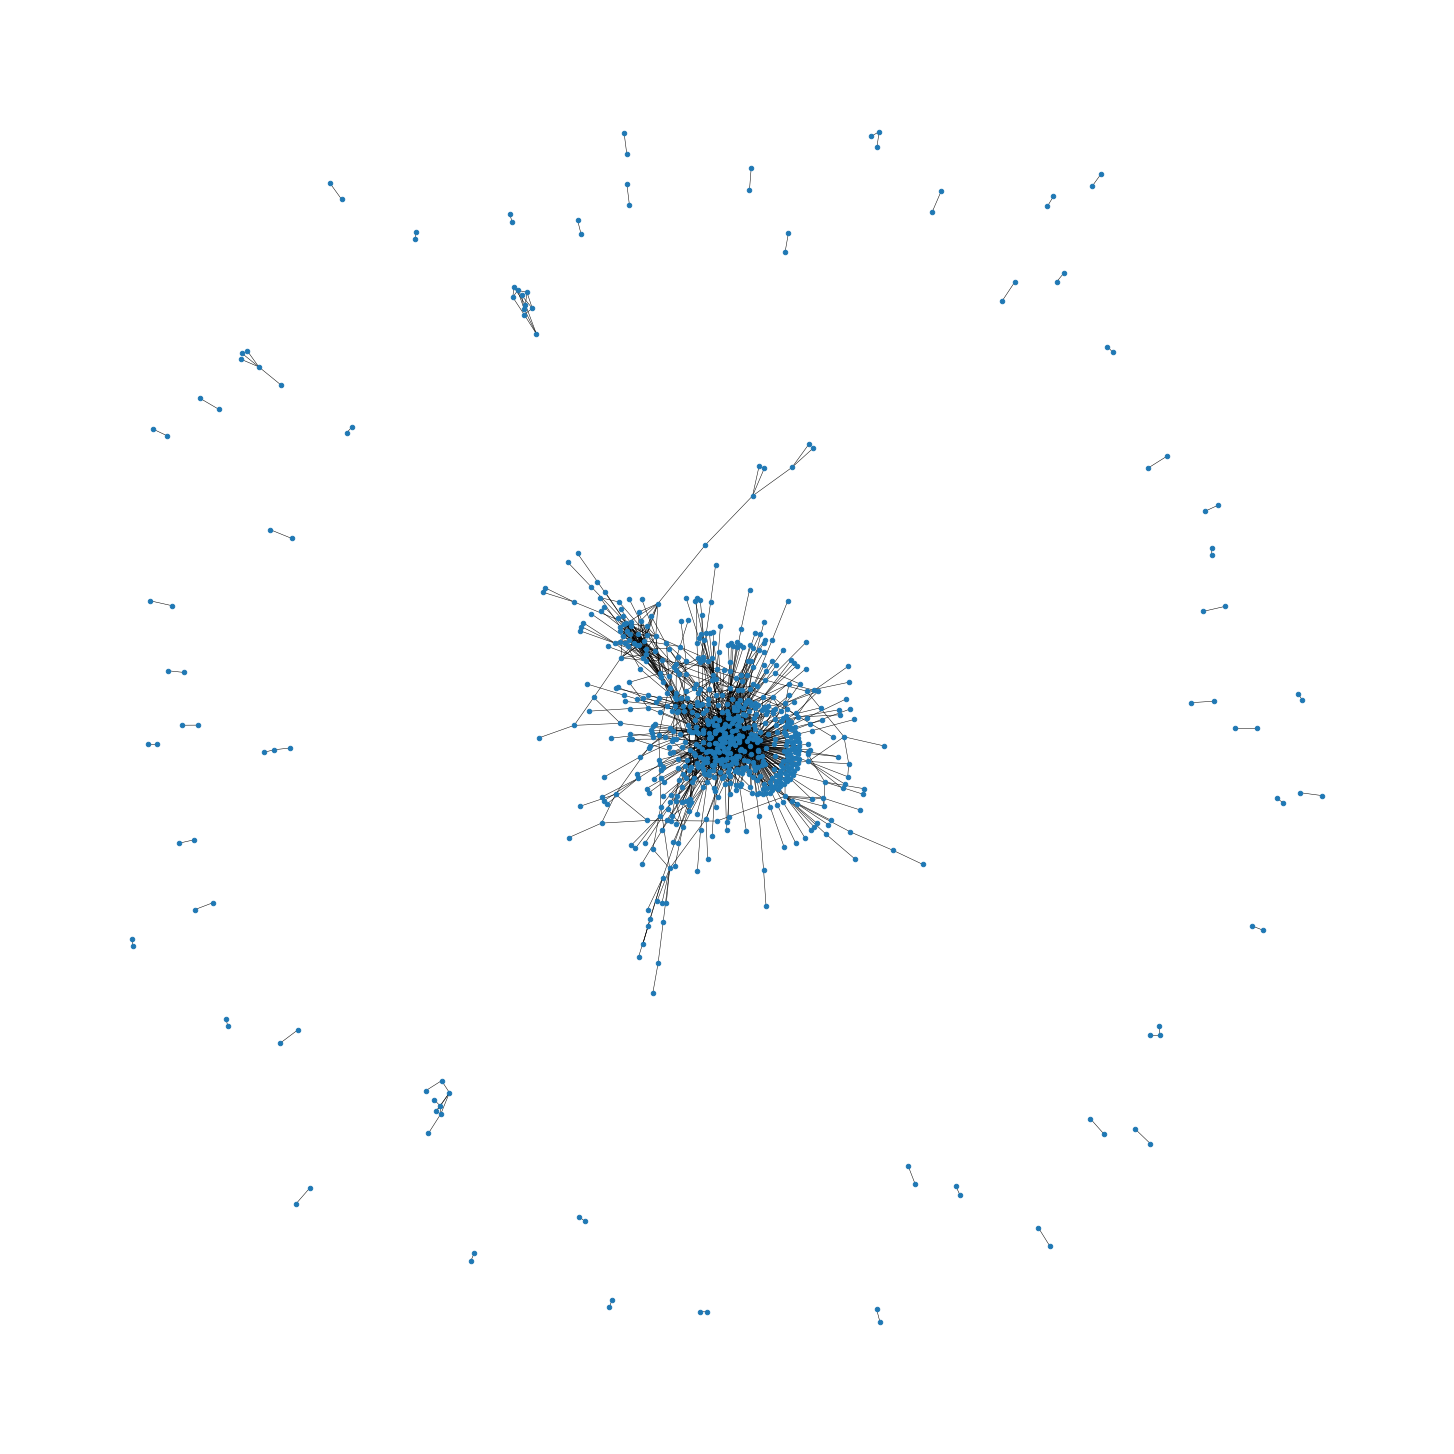

In [555]:
graph_waterparks = make_graph(dict_friends)
graph_waterparks

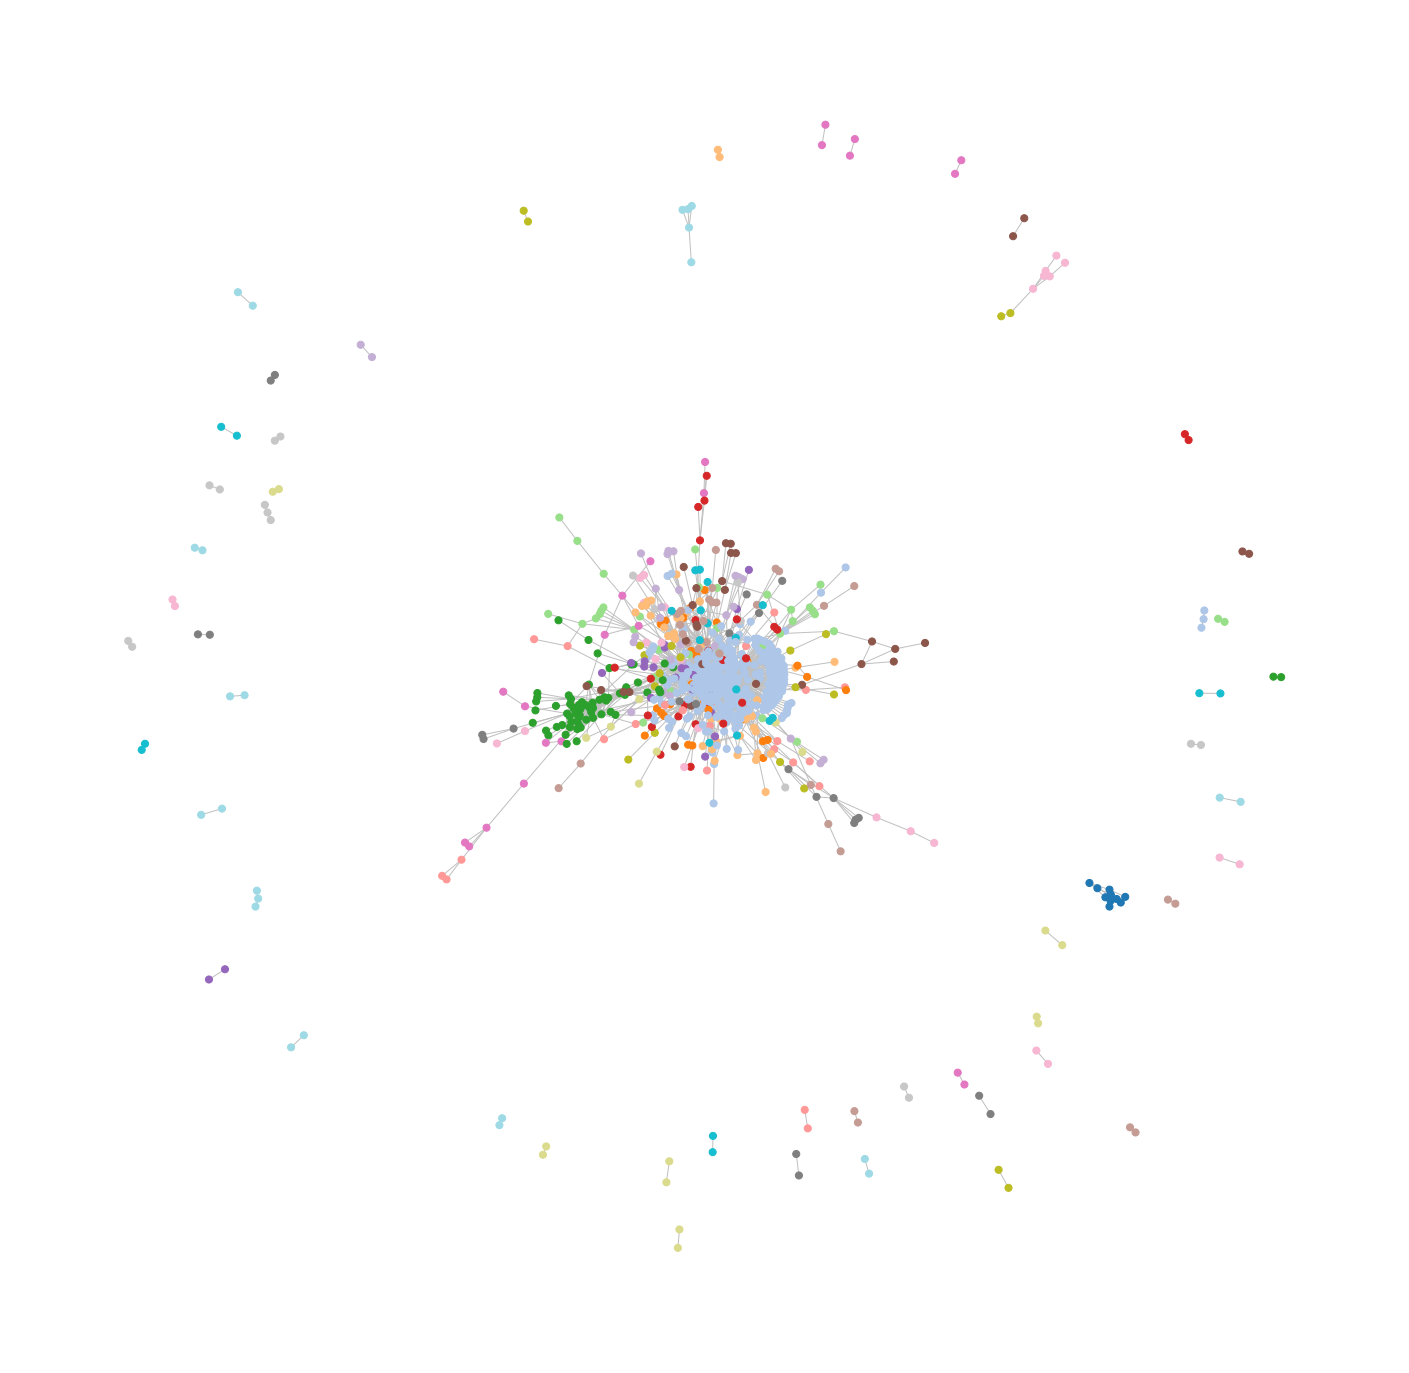

'Количество кластеров: 184'

In [553]:
clustering(graph_waterparks)

In [550]:
print('Количество узлов: ', len(graph_waterparks.nodes()))

Количество узлов:  824


In [551]:
print('Количество рёбер: ', len(graph_waterparks.edges()))

Количество рёбер:  1807


### Социальный граф для 5 Seconds Of Summer

In [557]:
for i in range(len(users_5sos)):
    user_friends_list(users_5sos[i], users_5sos)

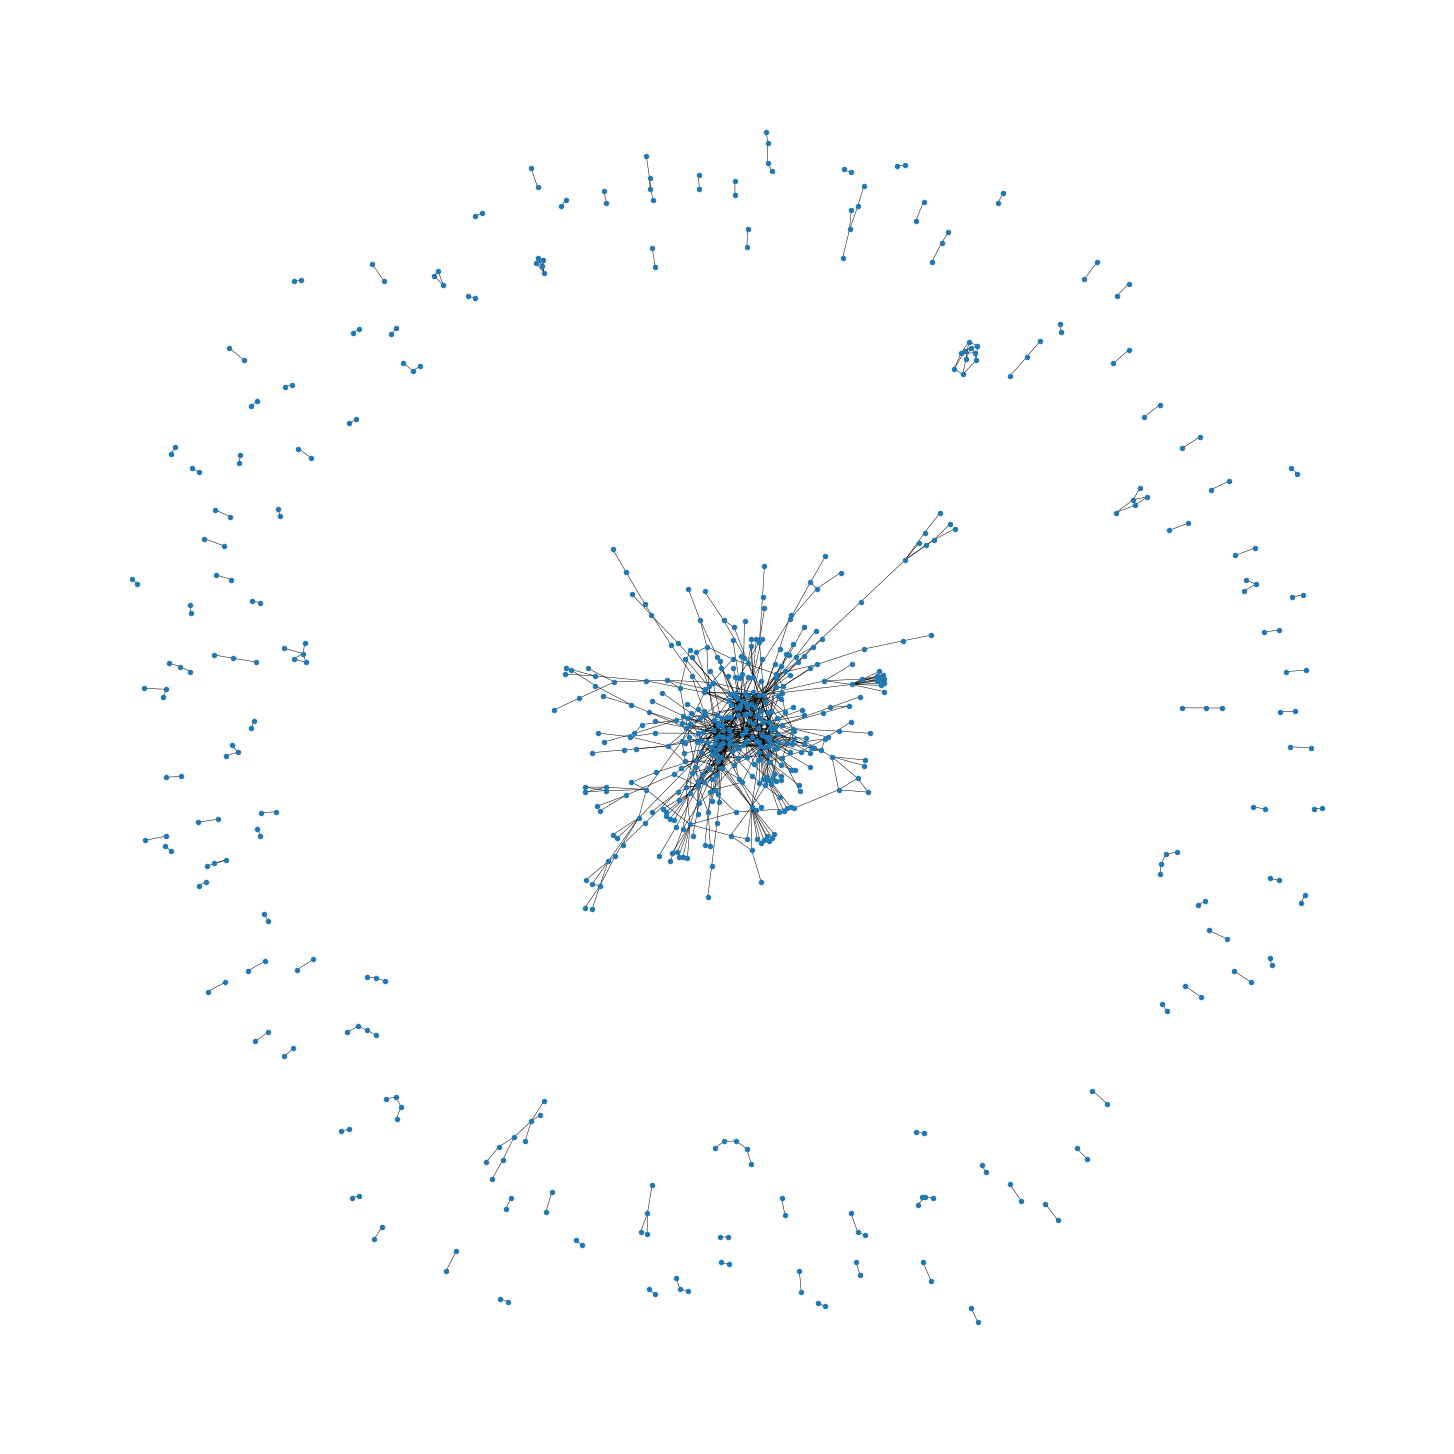

In [558]:
graph_5sos = make_graph(dict_friends)
graph_5sos

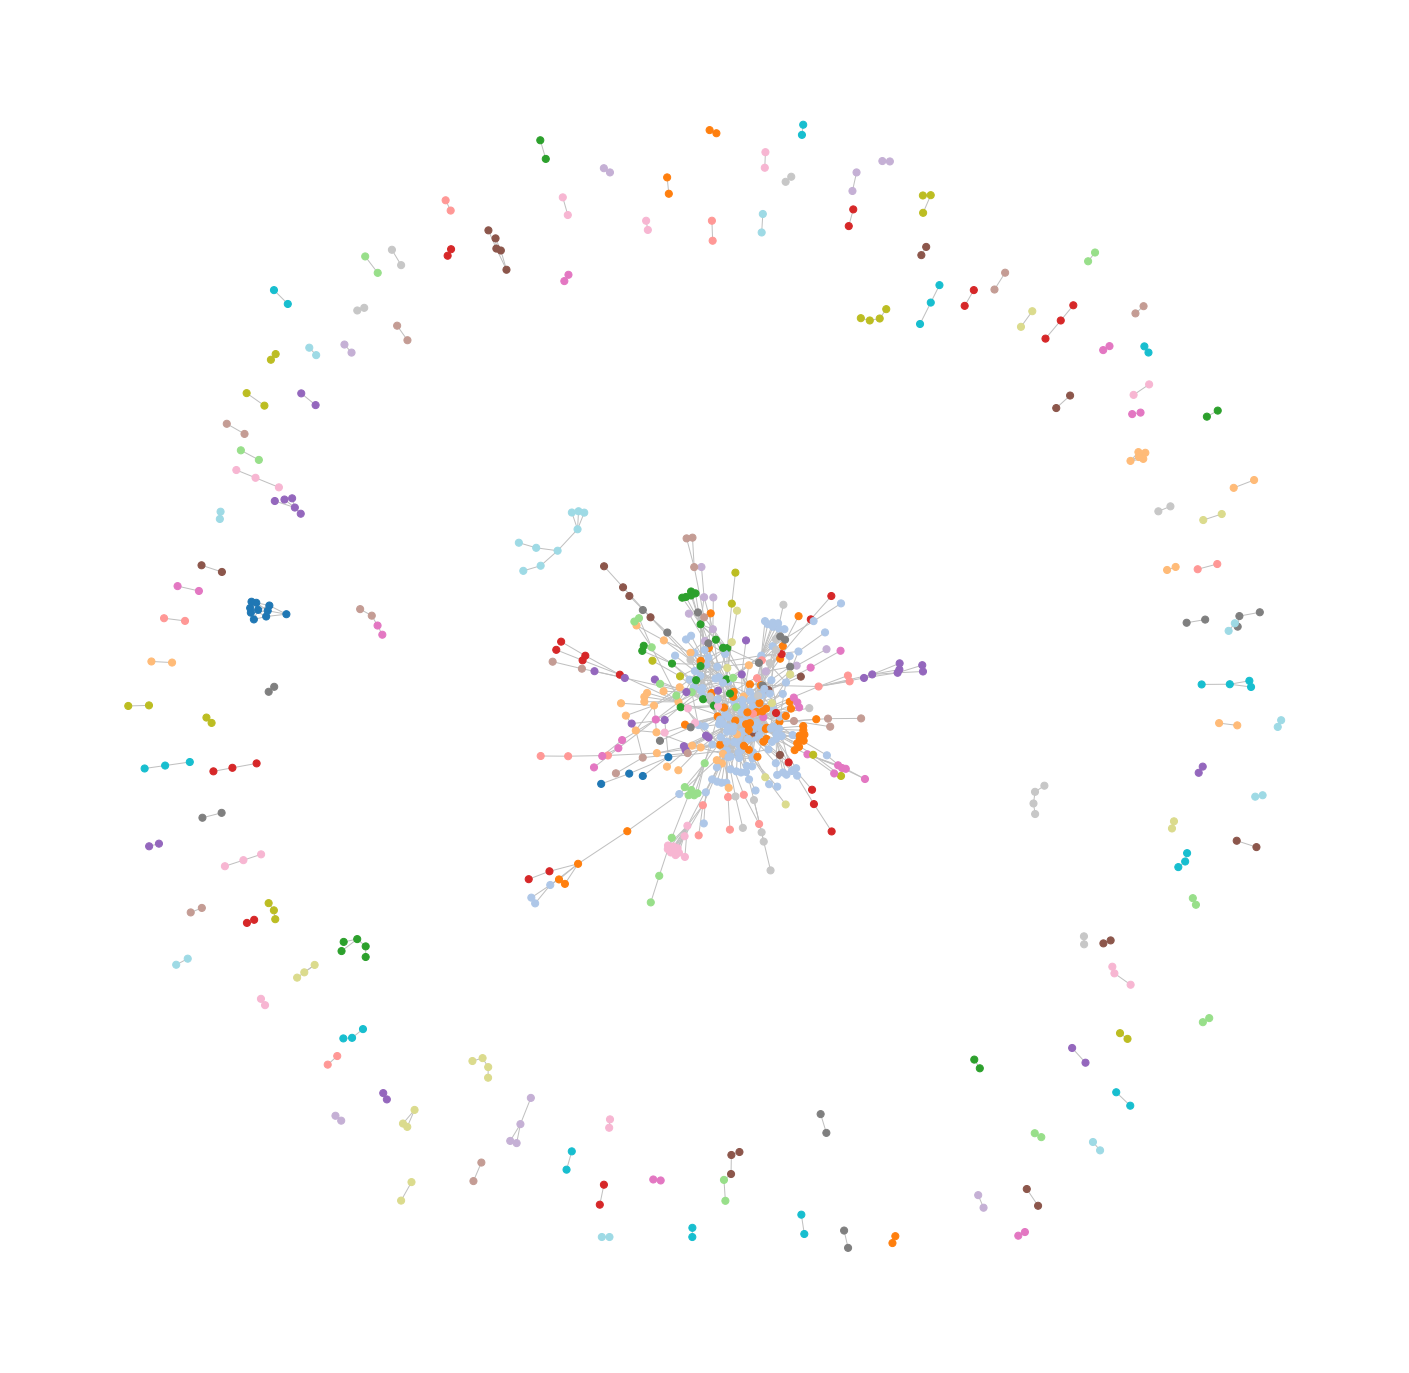

'Количество кластеров: 233'

In [559]:
clustering(graph_5sos)

In [560]:
print('Количество узлов: ', len(graph_5sos.nodes()))

Количество узлов:  700


In [561]:
print('Количество рёбер: ', len(graph_5sos.edges()))

Количество рёбер:  1032


### Социальный граф для обоих сообществ

In [562]:
for i in range(len(users_waterparks)):
    user_friends_list(users_waterparks[i], users_waterparks)

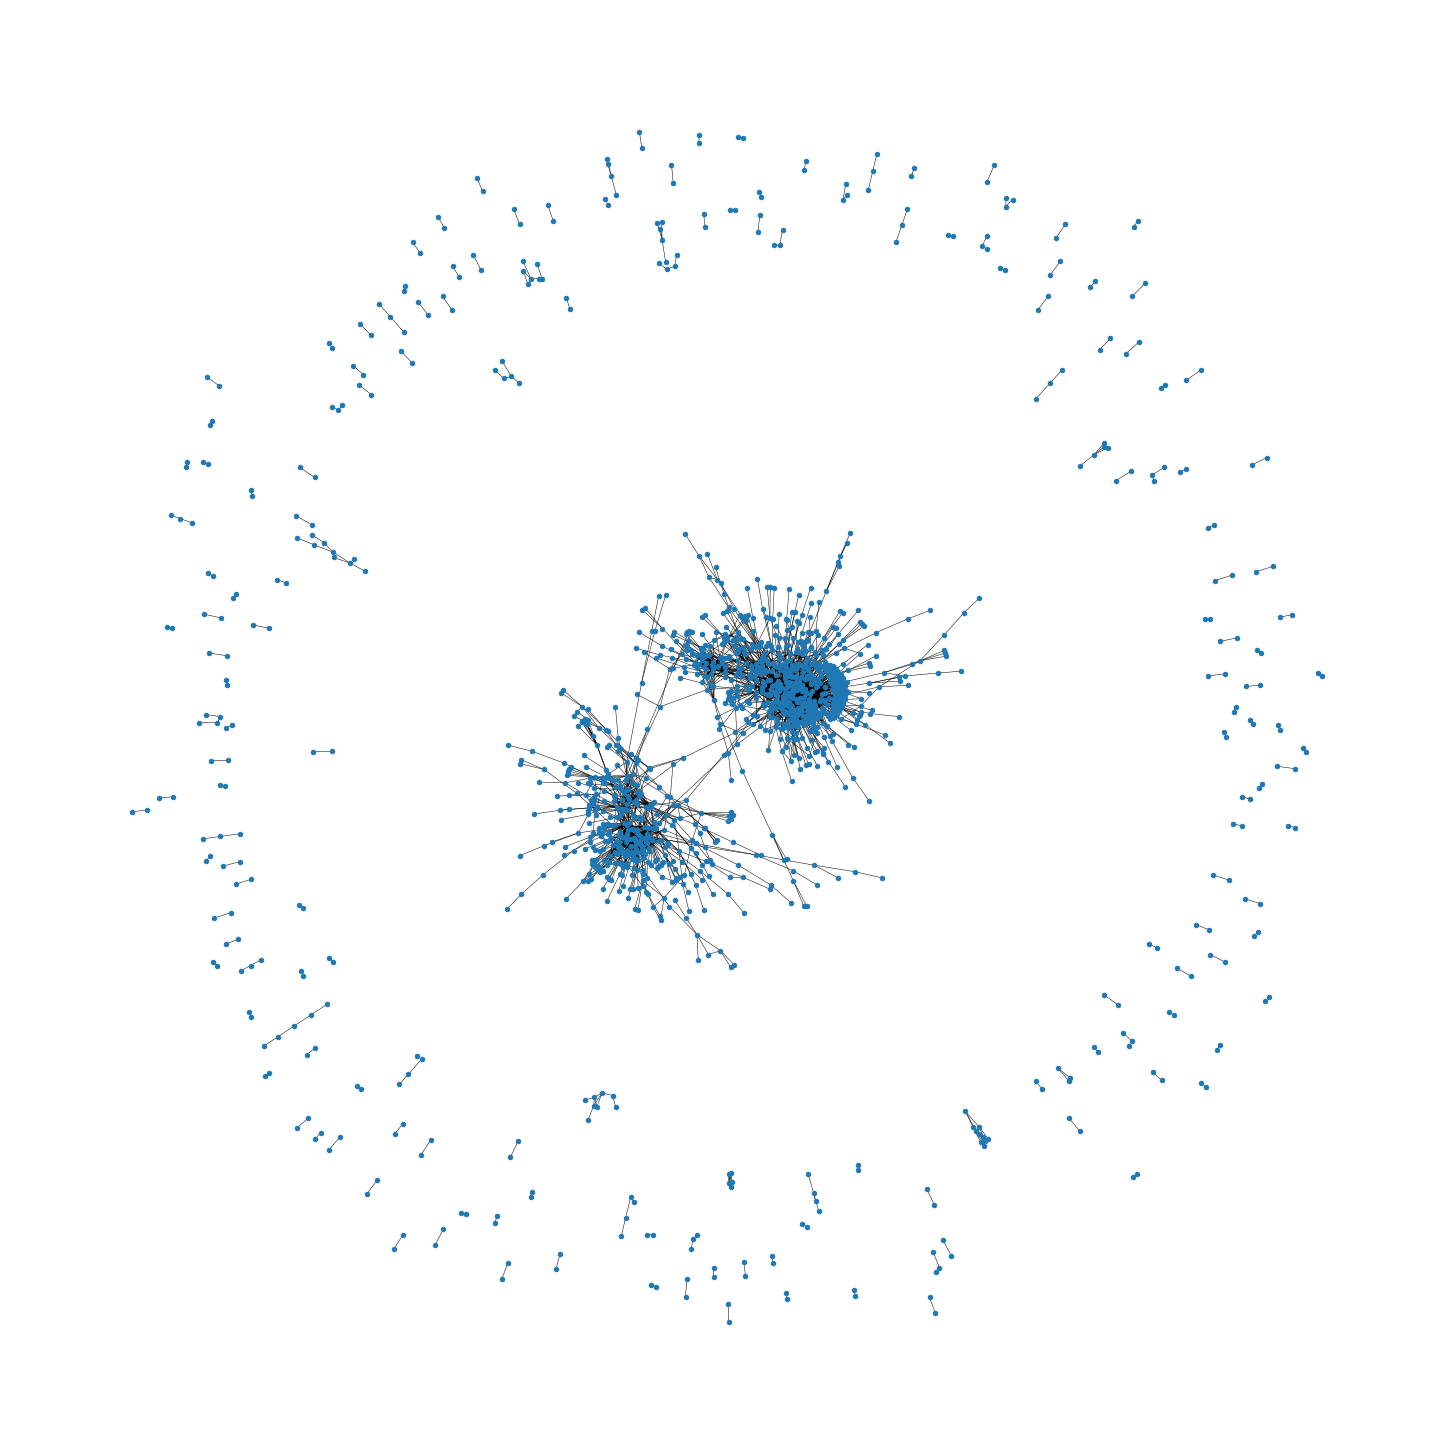

In [563]:
graph_all = make_graph(dict_friends)
graph_all

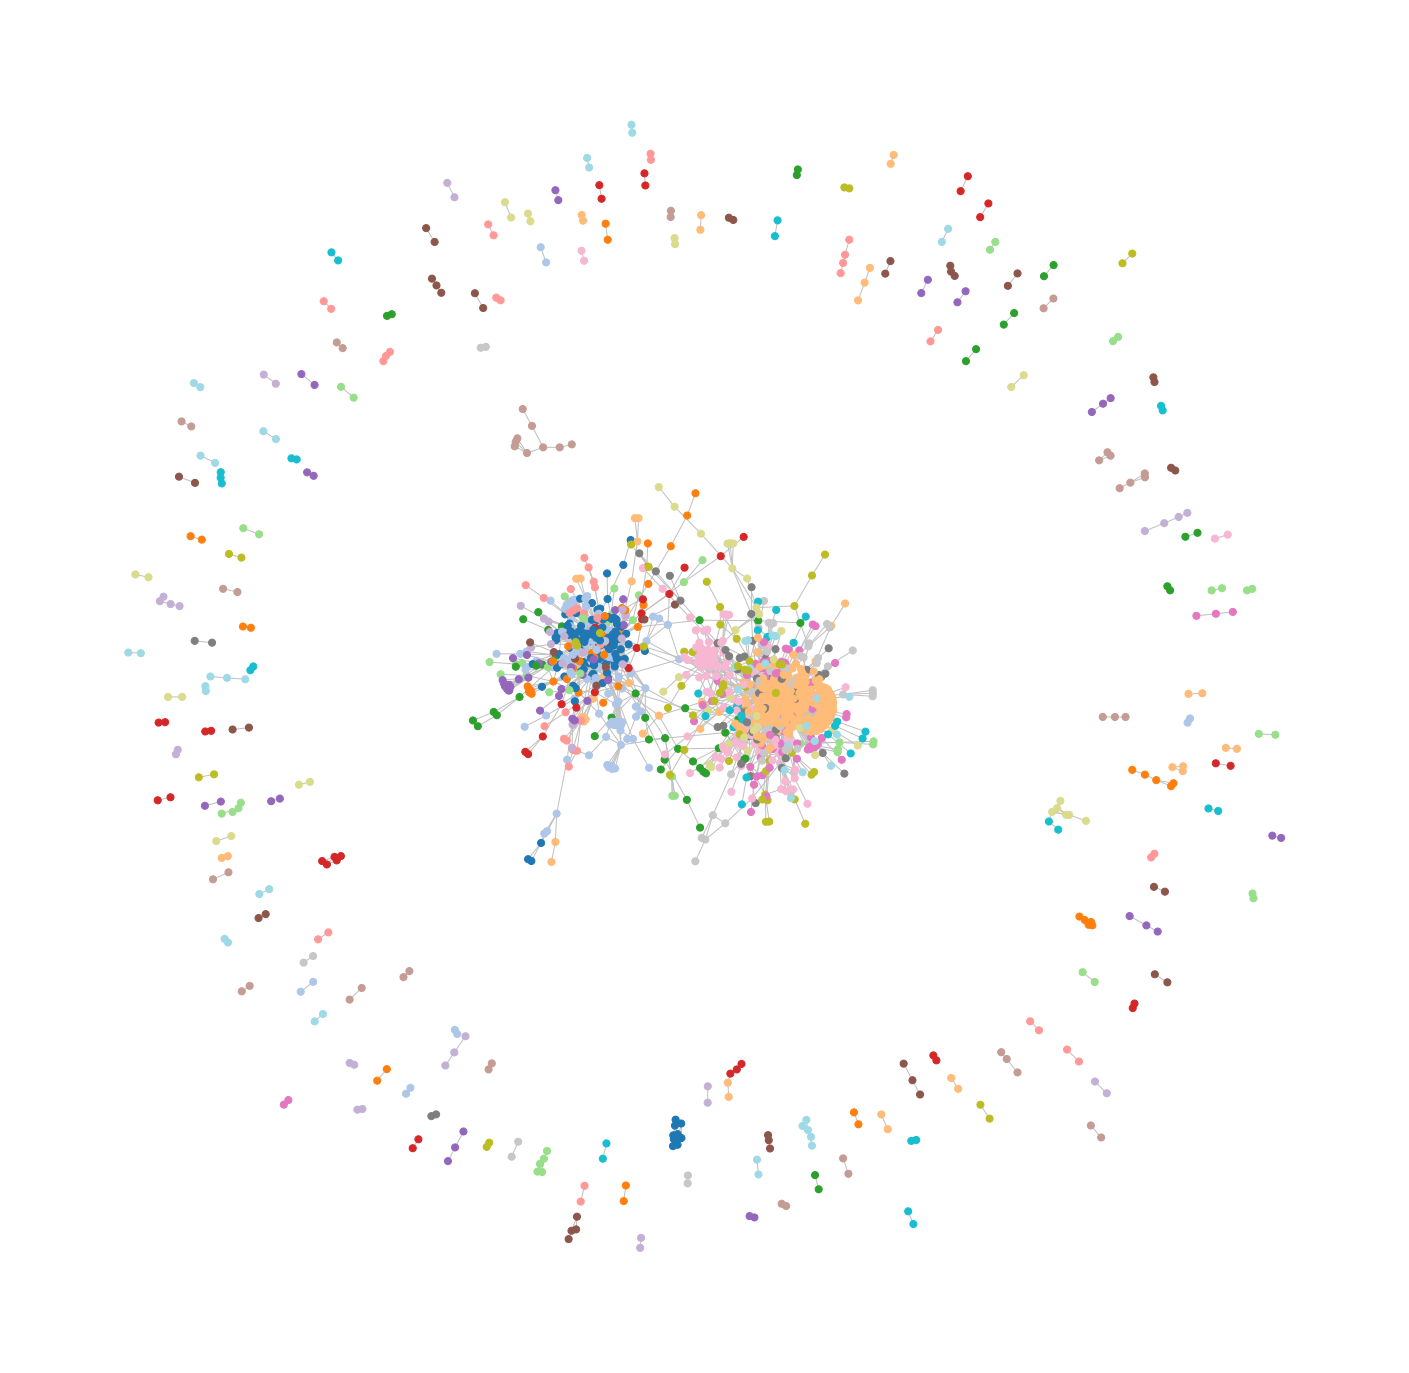

'Количество кластеров: 405'

In [564]:
clustering(graph_all)

In [565]:
print('Количество узлов: ', len(graph_all.nodes()))

Количество узлов:  1509


In [566]:
print('Количество рёбер: ', len(graph_all.edges()))

Количество рёбер:  2819
